Populating the interactive namespace from numpy and matplotlib


/home/tarang/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


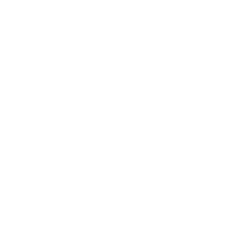

In [3]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import DBSCAN
from sklearn import metrics
import pylab as pl
from scipy.spatial import ConvexHull, convex_hull_plot_2d
pl.axis("off")   # turns off axes
pl.axis("tight")  # gets rid of white border
pl.axis("image")
# from matplotlib import animation, rc
# from IPython.display import HTML
from IPython import display
# pl.ion()

In [4]:
!pwd

/home/tarang/Lidar_Project_Fall_2019_Tarang/April2020/Lidar_curb_detection/source/vscan_only/boundary_detector_python


In [5]:
def visualize_dbscan(db):
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

    #     xy = X[class_member_mask & ~core_samples_mask]
    #     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #              markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

In [6]:
def getBoundary(points):
    added_vertices = [points.shape[0]-1,points.shape[0]-2]
    if(len(points)<3):
        return None, []
    hull = ConvexHull(points)
    vs = list(hull.vertices)
    for v in added_vertices:
        if v in vs:
            vs.remove(v)
    boundary = points[vs]
    return hull, boundary

def detect_boundary_6priors(df):
    # Convert to numpy and do DBScan clustering
    X = df.to_numpy()[:,:2]
    db = DBSCAN(eps=0.5, min_samples=2).fit(X)

    # Visualize dbscan clusters
    # visualize_dbscan(db)

#     print("Original Points:",df.to_numpy()[:,:2].shape[0])

    # visualize points that were clustered
    # pl.scatter(X[db.core_sample_indices_][:,0],X[db.core_sample_indices_][:,1])

    filtered_X = X[db.core_sample_indices_]

    # using 2 priors for now (y>0 and y<0)
    # prior1 = df[df.y>0].to_numpy()[:,:2]
    # prior2 = df[df.y<=0].to_numpy()[:,:2]
    prior1_y = filtered_X[filtered_X[:,1]>0,:]
    prior2_y = filtered_X[filtered_X[:,1]<=0,:]


    """
    Priors 

    0    X1    X2     W      
    -------------------
    |    |     |      |
    | 1  |  2  |  3   |
    |    |     |      |
    0]>--+-----+------+
    |    |     |      |
    | 4  |  5  |  6   |
    |    |     |      |
    -------------------

    """
    # split priors by X values
    xlim1 = 7
    xlim2 = 15
#     print("Length of upper half:",len(prior1_y))
    prior1 = prior1_y[prior1_y[:,0]<xlim1,:]
    prior2 = prior1_y[np.logical_and(prior1_y[:,0]>=xlim1,prior1_y[:,0]<xlim2),:]
    prior3 = prior1_y[prior1_y[:,0]>=xlim2,:]
#     print("Length of upper priors:",prior1.shape,prior2.shape,prior3.shape)
# 
#     print("Length of lower half:",len(prior2_y))
    prior4 = prior2_y[prior2_y[:,0]<xlim1,:]
    prior5 = prior2_y[np.logical_and(prior2_y[:,0]>=xlim1,prior2_y[:,0]<xlim2),:]
    prior6 = prior2_y[prior2_y[:,0]>=xlim2,:]
#     print("Length of lower priors:",prior4.shape,prior5.shape,prior6.shape)

    # # add points to prior
    # 0,maxY and maxX,maxY to prior1
    # 0, minY and maxX,minY to prior2

    maxX = np.max(filtered_X[:,0])
    maxY = np.max(filtered_X[:,1])
    minY = np.min(filtered_X[:,1])
    # print(prior1.shape, prior2.shape)
    # print(maxX,maxY,minY)
    prior1 = np.vstack([prior1,np.array([[0,maxY],[xlim1,maxY]])])
    prior2 = np.vstack([prior2,np.array([[xlim1,maxY],[xlim2,maxY]])])
    prior3 = np.vstack([prior3,np.array([[xlim2,maxY],[maxX,maxY]])])

    prior4 = np.vstack([prior4,np.array([[0,minY],[xlim1,minY]])])
    prior5 = np.vstack([prior5,np.array([[xlim1,minY],[xlim2,minY]])])
    prior6 = np.vstack([prior6,np.array([[xlim2,minY],[maxX,minY]])])
    # print(prior1.shape, prior2.shape)

    # plot priors
    # pl.scatter(prior1[:,0],prior1[:,1])
    # pl.scatter(prior2[:,0],prior2[:,1])

    priors = [prior1,prior2,prior3,prior4,prior5,prior6]
    hulls = []
    boundaries = []
    for prior in priors:
        hull, boundary = getBoundary(prior)
        hulls.append(hull)
        boundaries.append(boundary)

    return priors,boundaries

def is_dist_matchable(boundary1,boundary2,thres):
    dist = np.linalg.norm(boundary1[-1],boundary2[0])
    return dist<thres

def merge_set(boundaries):
    merged = []
    DIST_THRES = 5 #metres

    if (is_dist_matchable(boundaries[0],boundaries[1],DIST_THRES)):
        if(is_dist_matchable(boundaries[1],boundaries[2],DIST_THRES)):
            merged.append(np.vstack([boundaries[0],boundaries[1],boundaries[2]]))
        else:
            merged.append(np.vstack([boundaries[0],boundaries[1]]))
            merged.append(boundaries[2])
    else:
        if(is_dist_matchable(boundaries[1],boundaries[2],DIST_THRES)):
            merged.append(boundaries[0])
            merged.append(np.vstack([boundaries[1],boundaries[2]]))
        else:
            merged.append(boundaries[0])
            merged.append(boundaries[1])
            merged.append(boundaries[2])
    return merged

def merge_boundaries(boundaries):
    """ 
    `boundaries` is an array of 6 boundaries(1 for each prior)
    This function matches the upper and lower halves based on a distance metric
    """
    upper_boundaries = merge_set(boundaries[:3])
    lower_boundaries = merge_set(boundaries[3:])
    return upper_boundaries+lower_boundaries


../2011_09_26_drive_0005_sync_vscan/frame_75.csv


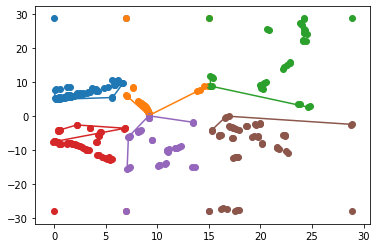

../2011_09_26_drive_0005_sync_vscan/frame_76.csv


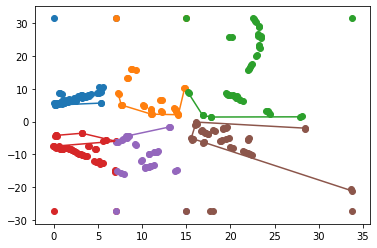

../2011_09_26_drive_0005_sync_vscan/frame_77.csv


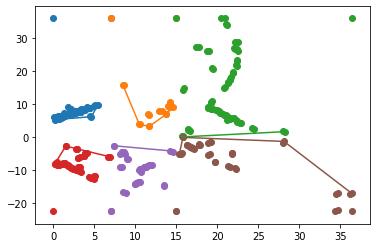

../2011_09_26_drive_0005_sync_vscan/frame_78.csv


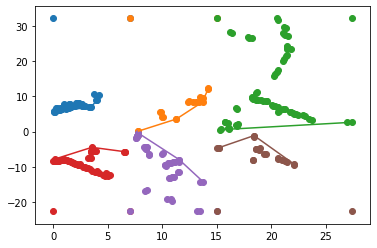

../2011_09_26_drive_0005_sync_vscan/frame_79.csv


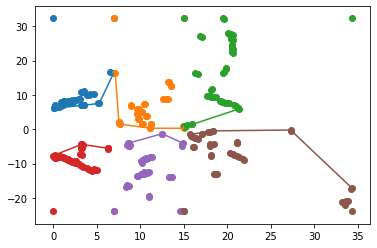

../2011_09_26_drive_0005_sync_vscan/frame_80.csv


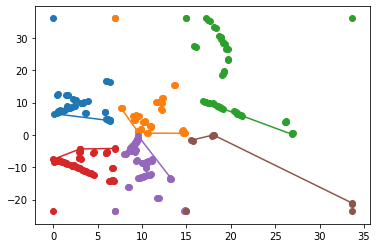

../2011_09_26_drive_0005_sync_vscan/frame_81.csv


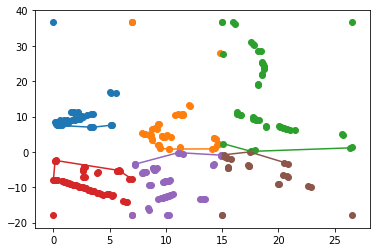

../2011_09_26_drive_0005_sync_vscan/frame_82.csv


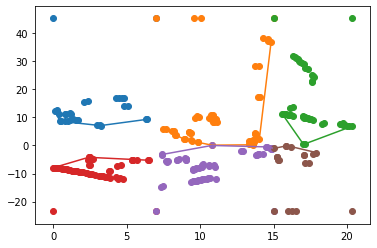

../2011_09_26_drive_0005_sync_vscan/frame_83.csv


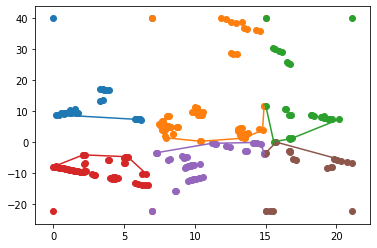

../2011_09_26_drive_0005_sync_vscan/frame_84.csv


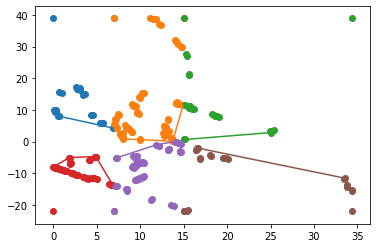

../2011_09_26_drive_0005_sync_vscan/frame_85.csv


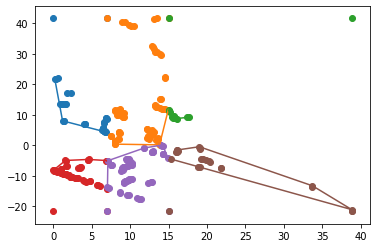

../2011_09_26_drive_0005_sync_vscan/frame_86.csv


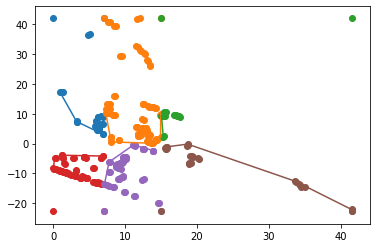

../2011_09_26_drive_0005_sync_vscan/frame_87.csv


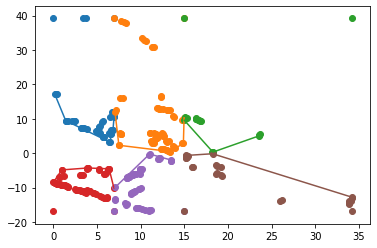

../2011_09_26_drive_0005_sync_vscan/frame_88.csv


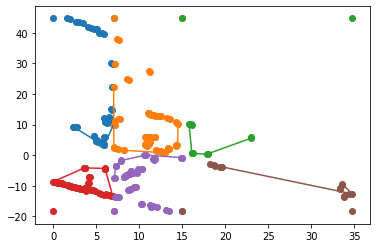

../2011_09_26_drive_0005_sync_vscan/frame_89.csv


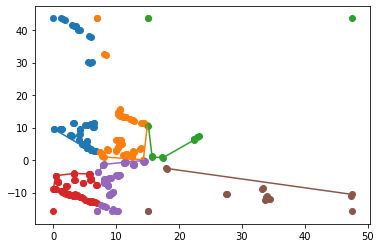

../2011_09_26_drive_0005_sync_vscan/frame_90.csv


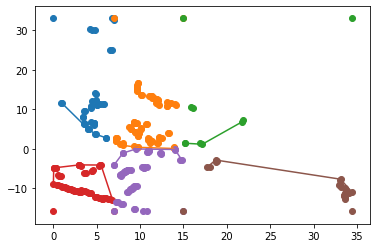

../2011_09_26_drive_0005_sync_vscan/frame_91.csv


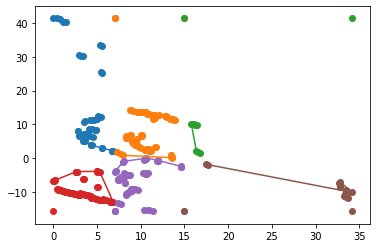

../2011_09_26_drive_0005_sync_vscan/frame_92.csv
no boundary for this prior


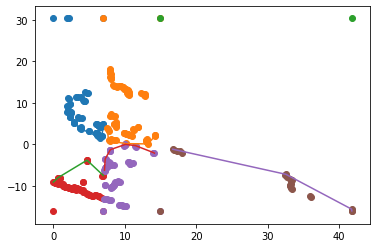

../2011_09_26_drive_0005_sync_vscan/frame_93.csv


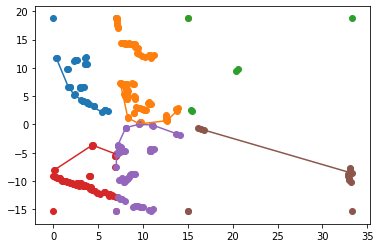

../2011_09_26_drive_0005_sync_vscan/frame_94.csv
no boundary for this prior


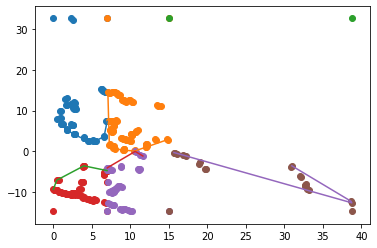

In [9]:
#visualize multiple frames
def detect_in_frame(filename):
    print(filename)
    df = pd.read_csv(filename)
#     print(len(df))

    priors, boundaries = detect_boundary_6priors(df)
        
    for idx,prior in enumerate(priors):
        # visualize points and line
        pl.scatter(prior[:,0],prior[:,1])
        if(len(boundaries[idx])>0):
            pl.plot(boundaries[idx][:,0],boundaries[idx][:,1])
        else:
            print("no boundary for this prior")
    pl.show()
    
frames = range(75,95)
for f in frames:
    filename = f"../2011_09_26_drive_0005_sync_vscan/frame_{f}.csv"
    detect_in_frame(filename)